## demo dropout

In this demo, the dropout as a regularization method will be displayed. Following the setup described in [__Improving neural networks by preventing co-adaptation of feature detectors__](https://arxiv.org/pdf/1207.0580.pdf) by Hinton et al. In particular, comparing an MLP with two hidden layers with and without the dropout on MNIST dataset.


In [1]:
import torch
from torchvision import datasets
from torchvision import transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

Firstly building a multilayer perceptron (MLP) according to the Hinton's paper. This network has 2 hidden layer with 800 hidden units per hidden layer. PyTorch enables to easily add dropout (just one line of code). Note that,
1. the activation functions are tanh
2. Adding a dropout layer after the input.
3. Use a dropout right after the first hidden layer.

Note that in most activation functions including tanh used here and ReLU, $f(0) = 0$ , so it does not matter if putting the dropout before or after the activation function. Also, remember, usually dropout will be used with fc layers (used in MLPs for example).


In [2]:
class MLP_Model(nn.Module):
    def __init__(self, hidden_layers=[800, 800], droprates=[0, 0]):
        super(MLP_Model, self).__init__()
        self.fc1 = torch.nn.Linear(784, hidden_layers[0])
        self.fc2 = torch.nn.Linear(hidden_layers[0], hidden_layers[0])
        self.fc3 = torch.nn.Linear(hidden_layers[0],10)
        self.dropout0 = torch.nn.Dropout(droprates[0])
        self.dropout1 = torch.nn.Dropout(droprates[1])

    def forward(self, x):
        # convert 28x28 images to 784 vectors
        x = x.view(x.shape[0], 28*28)
        x = self.dropout0(x)

        #  1st hidden layer
        x = torch.tanh(self.fc1(x))
        x = self.dropout1(x)

        # 2nd hidden layer
        x = torch.tanh(self.fc2(x))


        # softmax classifier
        x = self.fc3(x)
        return x

The function below is used to perform one epoch of training.

In [3]:
def train_model(model, optimizer, criterion, train_loader):
    model.train()
    running_loss = 0
    for batch_idx, (imgs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(imgs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        running_loss += loss.item()
        optimizer.step()
    return (running_loss / len(trainloader))

use the following function to evaluate the performance of a model on the test data. Note that,
1. put the model into eval mode using model.eval(). This disables the dropout layers (among other things) during training and not at the test time.
2. "with torch.no_grad()" makes computations memory efficient (as many computations should be kept onlyif perform backprop)


In [4]:
def test_model(model, test_loader):
    with torch.no_grad():
        model.eval()
        correct_predictions = 0
        total_predictions = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            outputs = model(data.to(device))
            predicted = torch.argmax(outputs, 1)
            correct_predictions += (predicted == target.to(device)).sum().item()
            total_predictions += target.shape[0]
        return (total_predictions - correct_predictions)

In [6]:
# check and see if a GPU is available
GPU_indx = 0
device = torch.device(GPU_indx if torch.cuda.is_available() else 'cpu')

# use the MNIST dataset here. Make sure that the directories are set correctly or use _download=True_
# to download them automatically.
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(0, 1)])
trainset = datasets.MNIST(root='../data', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='../data', train=False, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 94312131.51it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 36707786.01it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26458436.71it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20374897.08it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



Examples of the MNIST dataset are shown below

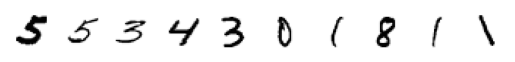

In [8]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
# plot 10 sample images
_,ax = plt.subplots(1,10)
ax = ax.flatten()
iml = images[0].numpy().shape[1]
[ax[i].imshow(np.transpose(images[i].numpy(),(1,2,0)).reshape(iml,-1),cmap='Greys') for i in range(10)]
[ax[i].set_axis_off() for i in range(10)]
plt.show()

To train the models, the cross entropy loss will be used. Train the models for 200 epochs

In [11]:
criterion = nn.CrossEntropyLoss()
max_epoch = 200

start by training an MLP without the dropout. Note that after each epoch, how many samples in the test set are not classified correctly will be counted. The code is slow on a CPU.

In [12]:
mlp0 = MLP_Model(droprates=[0.0, 0.0]).to(device)
optimizer_mlp0 = optim.SGD(mlp0.parameters(), lr=0.1, momentum=0)

loss_mlp0 = []
test_error_mlp0 = []
for epoch in range(max_epoch):
    mlp0.train()

    running_loss = 0
    for batch_idx, (imgs, labels) in enumerate(trainloader):
        optimizer_mlp0.zero_grad()
        outputs = mlp0(imgs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        running_loss += loss.item()
        optimizer_mlp0.step()


    loss_mlp0.append(running_loss / len(trainloader))



    num_error = test_model(mlp0, testloader)
    test_error_mlp0.append(num_error)
    if epoch % 10 == 0:
        print(f'MLP0 - Epoch:{epoch+1:3}|  loss = {loss_mlp0[-1]:.3f}| number of errors = {test_error_mlp0[-1]:.2f}|')

MLP0 - Epoch:  1|  loss = 0.508| number of errors = 860.00|
MLP0 - Epoch: 11|  loss = 0.119| number of errors = 397.00|
MLP0 - Epoch: 21|  loss = 0.054| number of errors = 254.00|
MLP0 - Epoch: 31|  loss = 0.027| number of errors = 218.00|
MLP0 - Epoch: 41|  loss = 0.013| number of errors = 201.00|
MLP0 - Epoch: 51|  loss = 0.007| number of errors = 206.00|
MLP0 - Epoch: 61|  loss = 0.004| number of errors = 197.00|
MLP0 - Epoch: 71|  loss = 0.002| number of errors = 187.00|
MLP0 - Epoch: 81|  loss = 0.002| number of errors = 194.00|
MLP0 - Epoch: 91|  loss = 0.001| number of errors = 189.00|
MLP0 - Epoch:101|  loss = 0.001| number of errors = 187.00|
MLP0 - Epoch:111|  loss = 0.001| number of errors = 189.00|
MLP0 - Epoch:121|  loss = 0.001| number of errors = 185.00|
MLP0 - Epoch:131|  loss = 0.001| number of errors = 185.00|
MLP0 - Epoch:141|  loss = 0.001| number of errors = 183.00|
MLP0 - Epoch:151|  loss = 0.000| number of errors = 183.00|
MLP0 - Epoch:161|  loss = 0.000| number 

Next train a model with 20% dropout at the input layer and 50% at the first hidden layer.

In [13]:
mlp1 = MLP_Model(droprates=[0.2, 0.5]).to(device)
optimizer_mlp1 = optim.SGD(mlp1.parameters(), lr=0.1, momentum=0)

loss_mlp1 = []
test_error_mlp1 = []
for epoch in range(max_epoch):
    running_loss = train_model(mlp1, optimizer_mlp1, criterion, trainloader)


    loss_mlp1.append(running_loss)



    num_error = test_model(mlp1, testloader)
    test_error_mlp1.append(num_error)
    if epoch % 10 == 0:
        print(f'MLP1 - Epoch:{epoch+1:3}|  loss = {loss_mlp1[-1]:.3f}| number of errors = {test_error_mlp1[-1]:.2f}|')

MLP1 - Epoch:  1|  loss = 0.568| number of errors = 871.00|
MLP1 - Epoch: 11|  loss = 0.191| number of errors = 393.00|
MLP1 - Epoch: 21|  loss = 0.115| number of errors = 288.00|
MLP1 - Epoch: 31|  loss = 0.082| number of errors = 243.00|
MLP1 - Epoch: 41|  loss = 0.067| number of errors = 205.00|
MLP1 - Epoch: 51|  loss = 0.055| number of errors = 183.00|
MLP1 - Epoch: 61|  loss = 0.047| number of errors = 178.00|
MLP1 - Epoch: 71|  loss = 0.043| number of errors = 162.00|
MLP1 - Epoch: 81|  loss = 0.035| number of errors = 177.00|
MLP1 - Epoch: 91|  loss = 0.032| number of errors = 170.00|
MLP1 - Epoch:101|  loss = 0.029| number of errors = 164.00|
MLP1 - Epoch:111|  loss = 0.028| number of errors = 159.00|
MLP1 - Epoch:121|  loss = 0.024| number of errors = 140.00|
MLP1 - Epoch:131|  loss = 0.022| number of errors = 146.00|
MLP1 - Epoch:141|  loss = 0.021| number of errors = 141.00|
MLP1 - Epoch:151|  loss = 0.019| number of errors = 145.00|
MLP1 - Epoch:161|  loss = 0.018| number 

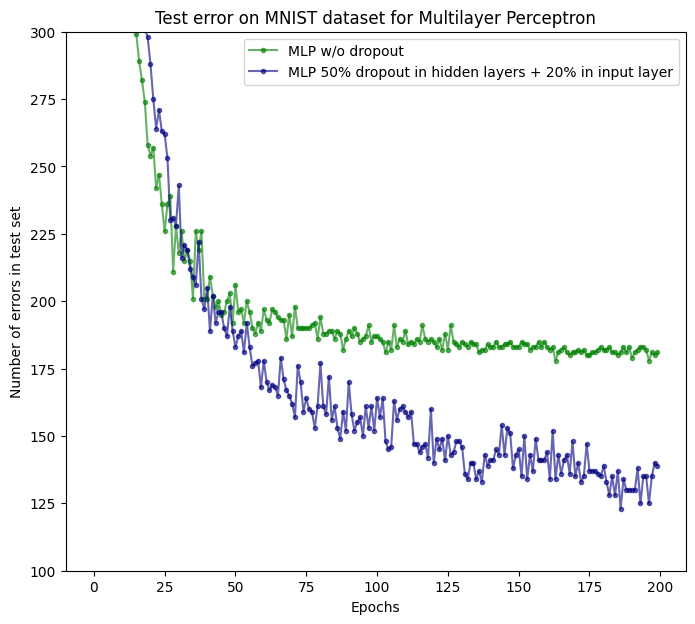

In [14]:
plt.figure(figsize=(8, 7))
plt.plot(test_error_mlp0, '.-', color='green', label='MLP w/o dropout', alpha=0.6);
plt.plot(test_error_mlp1, '.-', color='navy', label="MLP 50% dropout in hidden layers + 20% in input layer", alpha=0.6);
plt.ylim([100, 300]);
plt.legend(loc='upper right');
plt.xlabel('Epochs');
plt.ylabel('Number of errors in test set');
plt.title('Test error on MNIST dataset for Multilayer Perceptron')
plt.show()

From the result, dropout as regularization is useful and it successfully improves the network accuracy on the test set. In addition, further adding the dropout layer after the input layer will help as well.
